In [32]:
import numpy as np
import pandas as pd
import yfinance as yf

<Axes: xlabel='Date'>

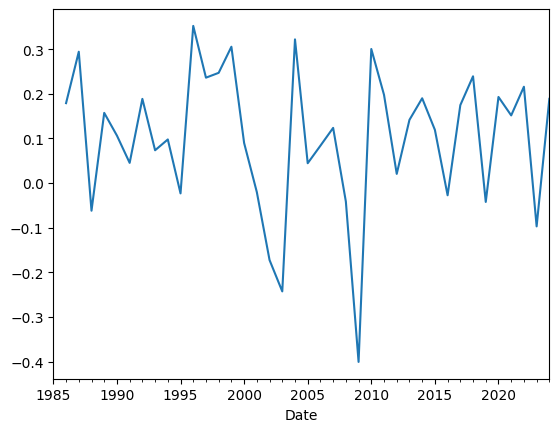

In [33]:
sp500 = yf.Ticker('^GSPC').history(start='1985-01-1', interval='1mo')
sp500 = sp500.iloc[::12, :].Close
sp500.index = sp500.index.tz_localize(None)
sp500.pct_change().plot()

In [34]:
def get_return_rate(df, shift):
    return np.power(df/df.shift(shift), (1/shift))-np.ones(df.shape[0])

In [35]:
sp500_return = pd.DataFrame({f'{freq}Y': get_return_rate(sp500, freq) for freq in [1, 5, 10, 20]}, index=sp500.index)
sp500_return.describe()

,1Y,5Y,10Y,20Y
count,39.000000,35.000000,30.000000,20.000000
mean,0.101165,0.086489,0.080712,0.067059
std,0.160228,0.074672,0.051749,0.016684
min,-0.400907,-0.060967,-0.042844,0.038118
25%,0.000020,0.033080,0.048777,0.054572
50%,0.123555,0.100859,0.092789,0.065472
75%,0.195238,0.133518,0.115153,0.076886
max,0.352026,0.242751,0.157083,0.098749


In [36]:
pce = pd.read_csv('../data/PCEPI.csv', index_col='DATE')
pce = pce.iloc[::12, :].PCEPI.pct_change()
pce.index = pce.index.astype('datetime64[ns]')
pce.index.name = 'Date'
pce.describe()

count    65.000000
mean      0.032861
std       0.024495
min      -0.001111
25%       0.016150
50%       0.024023
75%       0.042546
max       0.110913
Name: PCEPI, dtype: float64

In [37]:
df_inf = pd.merge(sp500, sp500_return, left_index=True, right_index=True).join(pce)
data = [df_inf.iloc[0].Close]
for idx, v in df_inf[1:].iterrows():
    i = len(data)
    data.append(data[i-1]*(1+v['1Y'])*(1-v.PCEPI))
inflation_returns = pd.Series(data, index=df_inf.index)

rate_w_inflation = pd.DataFrame({f'{freq}Y': get_return_rate(inflation_returns, freq) for freq in [1, 5, 10, 20]}, index=inflation_returns.index)
rate_w_inflation.describe()

,1Y,5Y,10Y,20Y
count,39.000000,35.000000,30.000000,20.000000
mean,0.075164,0.062350,0.058142,0.044767
std,0.157797,0.073756,0.050021,0.014117
min,-0.400241,-0.082055,-0.063286,0.018981
25%,-0.020847,0.012045,0.031800,0.035707
50%,0.105842,0.071869,0.067639,0.044258
75%,0.172871,0.114991,0.093001,0.055606
max,0.325339,0.221822,0.129545,0.071099


In [39]:
tax_rate = 0.2
data = {}
for freq in [10, 20]:
    gain = inflation_returns-inflation_returns.shift(freq)
    r_tax = (gain*(1-tax_rate))/inflation_returns.shift(freq)
    data[f'{freq}Y'] = np.power(1+r_tax, (1/freq))-1
rate_w_tax = pd.DataFrame(data, index=inflation_returns.index)
rate_w_tax.describe()

,10Y,20Y
count,30.000000,20.000000
mean,0.049877,0.038451
std,0.042172,0.012694
min,-0.047286,0.015688
25%,0.026116,0.030217
50%,0.056912,0.037850
75%,0.079391,0.048147
max,0.112527,0.062470
